#### Andrew Seeley
#### Prof. Binowski
#### 11/20/2024
#### Data Science Programming

This study scrapes data from Video Game Insights (VGI), a site that accumulates data from the gaming platform Steam. Once scraped, the data is cleaned and formatted into dataframes which are then used to draw conclusions about video game sales.

In [831]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import nest_asyncio
import asyncio
from playwright.async_api import async_playwright
from matplotlib import pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plot

### Question 1: Have VGI's Steam sales estimations gotten more accurate each year?

In [ ]:
url='https://vginsights.com/insights/article/steam-sales-estimation-methodology-and-accuracy'
response = requests.get(url)
status = response.status_code
if status == 200:
    page = response.text
    soup = bs(page)
else:
    print(f"Oops! Received status code {status}")

In [ ]:
print(soup.prettify())
type(soup)

In [ ]:
sales_list = [ ]
sales_table = soup.find(class_='wp-block-table').tbody

for row in sales_table.find_all('tr')[1:]:
    
    game = row.contents[0].text
    date = row.contents[1].text
    report = row.contents[2].text
    est = row.contents[3].text
    percent = row.contents[4].text
    
    sales_list.append({'game':game,'date':date, 'rep_units (mil)':report, 'est_units (mil)':est, 'perc_diff':percent})
    
print(sales_list)

sales_df = pd.DataFrame(sales_list)

Let's take a look at the data to see how it turned out.

In [ ]:
sales_df.head()

In [ ]:
sales_df.info()

A few things need to be cleaned up. The dates need to be converted to a datetime object, so we can extract the year. We also need to fix the percent error column to be a positive number, since we're only concerned with the magnitude of the error, not the direction.

In [ ]:
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [ ]:
sales_df['year'] = sales_df['date'].dt.year

In [ ]:
sales_df['perc_diff'] = sales_df['perc_diff'].str.rstrip('%').astype(float)

In [ ]:
sales_df['perc_diff'] = sales_df['perc_diff'].abs()

In [ ]:
sales_df.info()

In [ ]:
sales_df.head()

Now our data is in the right format to start manipulating it. First, we can look at the data in a table. Then we can plot it.

In [ ]:
errorbyyear = sales_df.groupby('year')['perc_diff'].mean()
errorbyyear

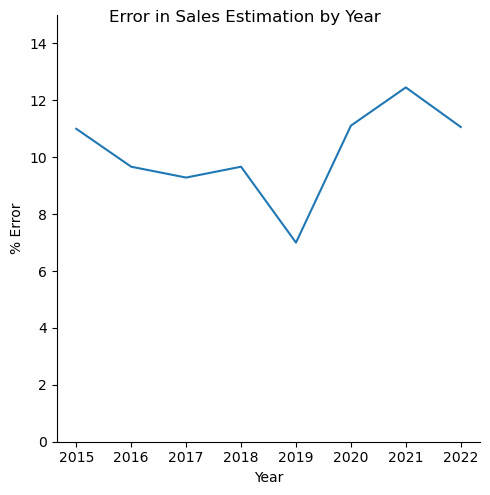

In [909]:
plot = sns.relplot(data=errorbyyear, kind='line')

plot.set_xlabels('Year')
plot.set_ylabels('% Error')
plot.fig.suptitle('Error in Sales Estimation by Year')
plot.set(ylim=(0, 15))

Conclusion: The data shows no significant improvement or decline in VGI's ability to accurately predict sales over the years. While there is some slight fluctuation, their estimates for any given year usually average out to about 10% error.

### Question 2: Do free-to-play games or pay-to-play games get more followers?

The rest of the data in this study came from more dynamic datasets; the tables were scrollable, so not all the data was visible at once. They were extracted using a different approach with the Playwright package. The following is a data scraping function that gets reused for the next three questions.

In [ ]:
# This function pulls from class notes as well as from chatGPT. AI helped create the code block that checks for a 'Next Page' button 
#and scrolls through each page to collect the entire table of data.
async def scrape_multipage(url):
    async with async_playwright() as p:
        # Launch browser
        browser = await p.chromium.launch(headless=False)  # Set headless=True for headless mode
        page = await browser.new_page()

        # Open the webpage with the table
        await page.goto(url)

        # Wait for the table to load initially
        await page.wait_for_selector("table")  # Adjust to a more specific table selector if necessary

        #Cumulative list of all rows from each page
        all_rows = []
        headers = []

        # Loop to click the "Next" button and scrape data
        while True:
            # Wait for the table to load (you can adjust the selector if necessary)
            table_html = await page.inner_html("table")
            
            # Extract the table HTML and parse it with BeautifulSoup
            soup = bs(table_html, "html.parser")

            # Extract headers (assuming <th> tags)
            hrows = soup.find_all("tr")
            header_row = hrows[1]  # The second row (0-indexed)
            headers = [th.text.strip() for th in header_row.find_all("th")]
            
            # Extract rows (assuming <tr> tags)
            rows = []
            for tr in soup.find_all("tr")[1:]:  # Skip the header row
                cells = tr.find_all("td")
                row = [cell.text.strip() for cell in cells]
                rows.append(row)
            
            # Append the rows to the all_rows list
            all_rows.extend(rows)

            # Now try to click the "Next" button to load the next page of data
            try:
                # Wait for the "Next" button to be visible and click it
                next_button = await page.query_selector("button[aria-label='Next Page']") 
                if next_button:
                    await next_button.click()
                    await page.wait_for_timeout(2000)  # Wait for the page to load (adjust the timeout as needed)
                else:
                    break  # Break the loop if there's no "Next" button (end of pagination)
            except Exception as e:
                print("Error clicking next button:", e)
                break  # Break the loop if an error occurs or no next button is found

        # Close the browser
        await browser.close()

        # Create and return a DataFrame from the collected rows
        df = pd.DataFrame(all_rows, columns=headers)
        return df        


In [ ]:
url='https://vginsights.com/games-database'

games_df = asyncio.run(scrape_multipage(url))

In [ ]:
games_df.head()

Let's explore the game data a bit more.

In [ ]:
games_df.info()

In [ ]:
games_df[games_df['Name'].isnull()]

It looks like the data scraping brought some nulls into our dataframe. We'll have to remove those, and convert the prices into numeric values like we did before. For the prices that say 'Free', we'll change it to say 0 instead. Then we'll convert the followers to a numeric as well.

In [ ]:
games_df.dropna(inplace = True)

In [ ]:
games_df['Price'] = games_df['Price'].replace('Free', '$0')

In [ ]:
games_df['Price'] = games_df['Price'].str.strip('$').astype(float)

In [ ]:
games_df['Price']

In [ ]:
for value in games_df['Followers']:
    v = str(value).replace(',', '')    
    split = re.split('([km]+)', v)
    if 'k' in split:
        num = float(split[0])
        games_df['Followers'] = games_df['Followers'].replace(value, num * 1000)
    elif 'm' in split:
        num = float(split[0])
        games_df['Followers'] = games_df['Followers'].replace(value, num * 1000000)
    else:
        num = float(v)
        games_df['Followers'] = games_df['Followers'].replace(value, num)

In [ ]:
games_df['Followers']

In [ ]:
games_df.info()

Now that we have the right fields as numerics, our code is ready to answer our question.

In [ ]:
games_df['Free or Pay'] = games_df['Price'].apply(lambda x: 'Free' if x == 0 else 'Pay to Play')

In [1044]:
games_df.groupby('Free or Pay')['Followers'].sum()

Free or Pay
Free            42051560.0
Pay to Play    101244735.0
Name: Followers, dtype: float64

In [1046]:
games_df.groupby('Free or Pay')['Followers'].mean()

Free or Pay
Free           793425.660377
Pay to Play    489105.000000
Name: Followers, dtype: float64

Conclusions: While Pay to Play games have more followers due to sheer numbers, Free games have more followers per game on average. It stands to reason that Free games are more popular, but they don't make up a majority of the Steam market.

### Question 3: What percentage of a publisher's library is classified as action games, on average? What about other genres?

In [ ]:
url = 'https://vginsights.com/publishers-database'

publishers_df = asyncio.run(scrape_multipage(url))

In [ ]:
publishers_df

We'll first need to clean the data like before. We'll remove all the null values, then remove the percentage signs and make the values numeric.

In [ ]:
publishers_df.dropna(inplace = True)

In [ ]:
publishers_df['Action'] = publishers_df['Action'].str.rstrip('%').astype(float)
publishers_df['Casual'] = publishers_df['Casual'].str.rstrip('%').astype(float)
publishers_df['Adventure'] = publishers_df['Adventure'].str.rstrip('%').astype(float)
publishers_df['Simulation'] = publishers_df['Simulation'].str.rstrip('%').astype(float)
publishers_df['Strategy'] = publishers_df['Strategy'].str.rstrip('%').astype(float)
publishers_df['RPG'] = publishers_df['RPG'].str.rstrip('%').astype(float)
publishers_df['MMO'] = publishers_df['MMO'].str.rstrip('%').astype(float)
publishers_df['Racing'] = publishers_df['Racing'].str.rstrip('%').astype(float)
publishers_df['Sports'] = publishers_df['Sports'].str.rstrip('%').astype(float)

In [ ]:
publishers_df.info()

Now we can subset our data and make some visuals.

In [835]:
genres = publishers_df[['Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'MMO', 'Racing', 'Sports']]

percents = genres.mean().round(1)
sortperc = percents.sort_values(ascending = True)

Text(0, 0.5, 'Genre')

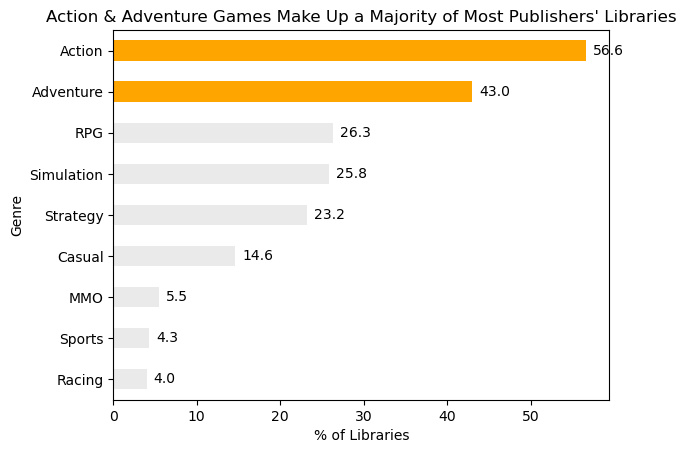

In [837]:
colors = ['#eaeaea']*7 + ['orange']*2
ax = sortperc.plot(kind='barh', color=colors)
for index, value in enumerate(sortperc): # Iterate through each row and isolate the x & y values
    ax.annotate(str(value), xy=(value, index), xytext=(5, 0), # Add the label to each bar
                textcoords='offset points', va='center') # Set alignment

plot.title("Action & Adventure Games Make Up a Majority of Most Publishers' Libraries")
plot.xlabel('% of Libraries')
plot.ylabel('Genre')

Conclusion: Two genres stand out as a large part of most publishers' libraries - action and adventure. MMO, Sports, and Racing games tend to only be a smaller portion of their libraries.

### Question 4: Do developers from different regions of the world make the same revenue per game, on average? Does their classification have any impact?

In [911]:
url = 'https://vginsights.com/developers-database'

developers_df = asyncio.run(scrape_multipage(url))

Error clicking next button: Timeout 30000ms exceeded.


In [913]:
developers_df

,#,Name,Classification,Released games,Unreleased games,Total revenue,Avg revenue per game,Med revenue per game [1],HQ country,% developed in-house,% indie releases,Action,Casual,Adventure,Simulation,Strategy,RPG,MMO,Racing,Sports
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1,Valve,AAA,36,1,$2.3bn,$64.2m,$45.8m,United States,35%,3%,78%,11%,11%,3%,11%,0%,3%,0%,0%
2,2,Ubisoft,AAA,122,1,$2bn,$16.2m,$1.8m,,28%,4%,90%,19%,72%,15%,13%,15%,7%,5%,11%
3,3,Capcom,AAA,84,2,$1.8bn,$21.3m,$5.3m,Japan,77%,1%,91%,0%,38%,0%,1%,13%,0%,0%,0%
4,4,Feral Interactive,AA,44,0,$1.8bn,$40.4m,$33.3m,United Kingdom,43%,0%,82%,0%,43%,27%,57%,9%,0%,30%,27%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,256,TheLiquidHorse,Indie,1,0,$47.2m,$47.2m,$47.2m,,0%,0%,100%,0%,0%,0%,0%,0%,100%,0%,0%
270,257,SgtOkiDoki,Indie,1,0,$47.2m,$47.2m,$47.2m,,1%,0%,100%,0%,0%,0%,0%,0%,100%,0%,0%
271,258,Vilaskis,Indie,1,0,$47.2m,$47.2m,$47.2m,,0%,0%,100%,0%,0%,0%,0%,0%,100%,0%,0%
272,259,Starbreeze Studios,Indie,6,0,$47.2m,$7.9m,$1.4m,Sweden,1%,17%,83%,0%,50%,0%,17%,33%,0%,0%,0%


First, similar to before, we need to reformat the revenue column. We also need to condense the countries to make the plot easier to read.

In [940]:
developers_df['Avg revenue per game']

1      64.2
2      16.2
3      21.3
4      40.4
5      72.8
       ... 
269    47.2
270    47.2
271    47.2
272     7.9
273    15.7
Name: Avg revenue per game, Length: 260, dtype: float64

In [918]:
developers_df.dropna(inplace = True)

In [920]:
developers_df['Avg revenue per game'] = developers_df['Avg revenue per game'].str.strip('$')

In [926]:
developers_df['Avg revenue per game'] = developers_df['Avg revenue per game'].str.strip('m')

In [1018]:
developers_df['Avg revenue per game'] = developers_df['Avg revenue per game'].replace('1.2bn', '1200')
developers_df = developers_df[developers_df['Avg revenue per game'] != 1200] # This value is an outlier so I've chosen to remove it to make the rest of the data more meaningful.

In [958]:
developers_df['HQ country'] = developers_df['HQ country'].replace('', 'International')

In [968]:
developers_df['HQ country'] = developers_df['HQ country'].replace(['United States', 'Canada', 'Mexico'], 'North America')

In [970]:
developers_df['HQ country'] = developers_df['HQ country'].replace(['United Kingdom', 'Poland', 'Belgium', 'Sweden', 'Netherlands', 'France', 'Ireland', 'Germany', 'Switzerland', 'Denmark', 'Spain', 'Croatia', 'Finland', 'Bulgaria', 'Estonia', 'Norway', 'Cyprus', 'Austria', 'Italy', 'Czech Republic'], 'Europe')

In [982]:
developers_df['HQ country'] = developers_df['HQ country'].replace(['Japan', 'China', 'Ukraine', 'Turkey'], 'Asia')

In [978]:
developers_df['HQ country'] = developers_df['HQ country'].replace('Colombia', 'South America')

In [974]:
developers_df['HQ country'] = developers_df['HQ country'].replace('Egypt', 'Africa')

In [984]:
developers_df['HQ country'].unique()

array(['North America', 'International', 'Asia', 'Europe', 'Africa',
       'South America', 'Australia'], dtype=object)

In [936]:
for value in developers_df['Avg revenue per game']:  
    developers_df['Avg revenue per game'] = developers_df['Avg revenue per game'].replace(value, float(value))

Now we can perform our calculations.

In [1022]:
classes = developers_df.groupby(['HQ country', 'Classification'])['Avg revenue per game'].mean()

In [1024]:
classdf = pd.DataFrame(classes)
classdf

Avg revenue per game
HQ country    Classification                      
Africa        Indie                     136.400000
Asia          AA                         48.750000
              AAA                        41.860000
              Indie                      74.338462
Australia     AA                         68.200000
              Indie                      29.100000
Europe        AA                         41.633333
              AAA                        32.100000
              Indie                      36.922581
International AA                         63.450000
              AAA                        78.716667
              Indie                      62.632143
North America AA                         56.190476
              AAA                        65.628571
              Indie                      58.223404
South America Indie                     114.100000

Text(0.5, 1.0, 'Indie Developers Stand Out As High Earners')

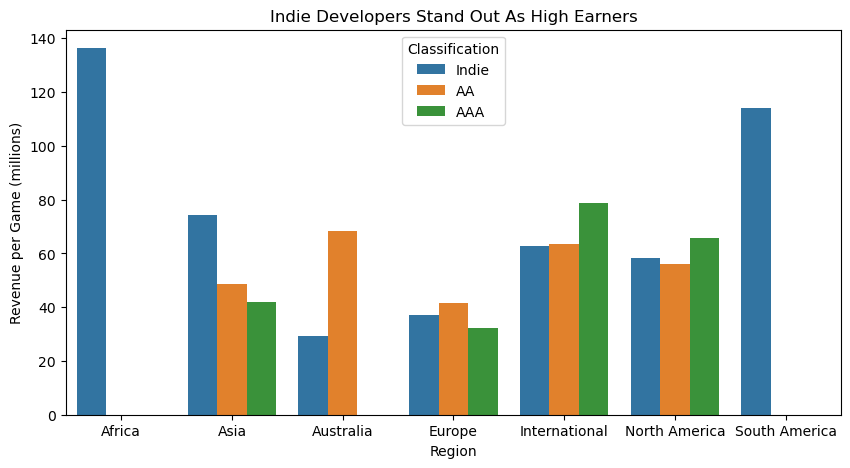

In [1041]:
plt.figure(figsize=(10, 5))
graph = sns.barplot(data=classdf, x = 'HQ country', y = 'Avg revenue per game', hue = 'Classification') 
plt.xlabel('Region')
plt.ylabel('Revenue per Game (millions)')
graph.set_title('Indie Developers Stand Out As High Earners')

Conclusions: South America and Africa stand out as earning the highest revenues per game, despite only having Indie developers. Most other regions are fairly distributed in their revenue both between regions and between developer classifications.